# Illya-BOICHUK-Camp-2025

## Answer

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [28]:
df = pd.read_csv('data/creditcard.csv').drop(['Time'], axis=1)
df = df.drop_duplicates().reset_index(drop=True)
features = ['V10', 'V14', 'V4', 'V12', 'V11', 'V17']
df_selected = df[features + ['Class']].copy()
print(f"Dataset size: {df_selected.shape}")
print(f"Number of classes: {df_selected['Class'].value_counts()}")
outlier_fraction = len(df[df['Class'] == 1])/float(len(df[df['Class'] == 0]))
print(f"Share of fraudulent transactions: {outlier_fraction:.4f}")

Dataset size: (275663, 7)
Number of classes: Class
0    275190
1       473
Name: count, dtype: int64
Share of fraudulent transactions: 0.0017


In [29]:
X = df_selected[features].copy()
y_true = df_selected['Class'].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("X shape:", X.shape)
print("y_true shape:", y_true.shape)
results = []

X shape: (275663, 6)
y_true shape: (275663,)


In [30]:
def IQR_method(df, n, features, k=1.5):
    outlier_list = []
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1
        outlier_step = k * IQR
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | 
                               (df[column] > Q3 + outlier_step)].index
        outlier_list.extend(outlier_list_column)
    
    outlier_list = Counter(outlier_list)
    multiple_outliers = list(k for k, v in outlier_list.items() if v > n)
    return multiple_outliers

outlier_indices = IQR_method(df_selected, n=1, features=features, k=4.5)
y_pred_iqr = np.zeros(len(df_selected))
y_pred_iqr[outlier_indices] = 1
print("Classification Report:")
print(classification_report(y_true, y_pred_iqr, target_names=['non-fraud', 'fraud']))

cm_iqr = confusion_matrix(y_true, y_pred_iqr)
cm_df_iqr = pd.DataFrame(cm_iqr,
                    index=['true_non-fraud', 'true_fraud'],
                    columns=['pred_non-fraud', 'pred_fraud'])
print("\nConfusion Matrix:")
print(cm_df_iqr)
precision_iqr = precision_score(y_true, y_pred_iqr)
recall_iqr = recall_score(y_true, y_pred_iqr)
f1_iqr = f1_score(y_true, y_pred_iqr)
results.append({
    'method': 'IQR Method',
    'precision': precision_iqr,
    'recall': recall_iqr,
    'f1_score': f1_iqr
})
print(f"IQR Method - Precision: {precision_iqr:.4f}, Recall: {recall_iqr:.4f}, F1: {f1_iqr:.4f}")

Classification Report:
              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00    275190
       fraud       0.55      0.63      0.59       473

    accuracy                           1.00    275663
   macro avg       0.78      0.82      0.79    275663
weighted avg       1.00      1.00      1.00    275663


Confusion Matrix:
                pred_non-fraud  pred_fraud
true_non-fraud          274949         241
true_fraud                 174         299
IQR Method - Precision: 0.5537, Recall: 0.6321, F1: 0.5903


In [31]:
iso_forest = IsolationForest(
    contamination=outlier_fraction,
    random_state=42,
    n_estimators=100
)

y_pred_iso = iso_forest.fit_predict(X_scaled)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
print("Classification Report:")
print(classification_report(y_true, y_pred_iso, target_names=['non-fraud', 'fraud']))

cm_iso = confusion_matrix(y_true, y_pred_iso)
cm_df_iso = pd.DataFrame(cm_iso,
                    index=['true_non-fraud', 'true_fraud'],
                    columns=['pred_non-fraud', 'pred_fraud'])
print("\nConfusion Matrix:")
print(cm_df_iso)
precision_iso = precision_score(y_true, y_pred_iso)
recall_iso = recall_score(y_true, y_pred_iso)
f1_iso = f1_score(y_true, y_pred_iso)

results.append({
    'method': 'Isolation Forest',
    'precision': precision_iso,
    'recall': recall_iso,
    'f1_score': f1_iso
})

print(f"Isolation Forest - Precision: {precision_iso:.4f}, Recall: {recall_iso:.4f}, F1: {f1_iso:.4f}")

Classification Report:
              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00    275190
       fraud       0.70      0.70      0.70       473

    accuracy                           1.00    275663
   macro avg       0.85      0.85      0.85    275663
weighted avg       1.00      1.00      1.00    275663


Confusion Matrix:
                pred_non-fraud  pred_fraud
true_non-fraud          275046         144
true_fraud                 143         330
Isolation Forest - Precision: 0.6962, Recall: 0.6977, F1: 0.6969


In [32]:
elliptic_env = EllipticEnvelope(
    contamination=outlier_fraction,
    random_state=42
)
y_pred_elliptic = elliptic_env.fit_predict(X_scaled)
y_pred_elliptic = np.where(y_pred_elliptic == -1, 1, 0)
print("Classification Report:")
print(classification_report(y_true, y_pred_elliptic, target_names=['non-fraud', 'fraud']))

cm_elliptic = confusion_matrix(y_true, y_pred_elliptic)
cm_df_elliptic = pd.DataFrame(cm_elliptic,
                    index=['true_non-fraud', 'true_fraud'],
                    columns=['pred_non-fraud', 'pred_fraud'])
print("\nConfusion Matrix:")
print(cm_df_elliptic)
precision_elliptic = precision_score(y_true, y_pred_elliptic)
recall_elliptic = recall_score(y_true, y_pred_elliptic)
f1_elliptic = f1_score(y_true, y_pred_elliptic)
results.append({
    'method': 'Elliptic Envelope',
    'precision': precision_elliptic,
    'recall': recall_elliptic,
    'f1_score': f1_elliptic
})

print(f"Elliptic Envelope - Precision: {precision_elliptic:.4f}, Recall: {recall_elliptic:.4f}, F1: {f1_elliptic:.4f}")


Classification Report:
              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00    275190
       fraud       0.64      0.64      0.64       473

    accuracy                           1.00    275663
   macro avg       0.82      0.82      0.82    275663
weighted avg       1.00      1.00      1.00    275663


Confusion Matrix:
                pred_non-fraud  pred_fraud
true_non-fraud          275021         169
true_fraud                 168         305
Elliptic Envelope - Precision: 0.6435, Recall: 0.6448, F1: 0.6441


In [33]:
lof = LocalOutlierFactor(
    contamination=outlier_fraction,
    n_neighbors=20
)

y_pred_lof = lof.fit_predict(X_scaled)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)
print("Classification Report:")
print(classification_report(y_true, y_pred_lof, target_names=['non-fraud', 'fraud']))
cm_lof = confusion_matrix(y_true, y_pred_lof)
cm_df_lof = pd.DataFrame(cm_lof,
                    index=['true_non-fraud', 'true_fraud'],
                    columns=['pred_non-fraud', 'pred_fraud'])
print("\nConfusion Matrix:")
print(cm_df_lof)
precision_lof = precision_score(y_true, y_pred_lof)
recall_lof = recall_score(y_true, y_pred_lof)
f1_lof = f1_score(y_true, y_pred_lof)
results.append({
    'method': 'Local Outlier Factor',
    'precision': precision_lof,
    'recall': recall_lof,
    'f1_score': f1_lof
})
print(f"Local Outlier Factor - Precision: {precision_lof:.4f}, Recall: {recall_lof:.4f}, F1: {f1_lof:.4f}")


Classification Report:
              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00    275190
       fraud       0.00      0.00      0.00       473

    accuracy                           1.00    275663
   macro avg       0.50      0.50      0.50    275663
weighted avg       1.00      1.00      1.00    275663


Confusion Matrix:
                pred_non-fraud  pred_fraud
true_non-fraud          274716         474
true_fraud                 473           0
Local Outlier Factor - Precision: 0.0000, Recall: 0.0000, F1: 0.0000


In [34]:
one_class_svm = OneClassSVM(
    nu=outlier_fraction,
    kernel="rbf",
    gamma="scale"
)

y_pred_svm = one_class_svm.fit_predict(X_scaled)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)
print("Classification Report:")
print(classification_report(y_true, y_pred_svm, target_names=['non-fraud', 'fraud']))
cm_svm = confusion_matrix(y_true, y_pred_svm)
cm_df_svm = pd.DataFrame(cm_svm,
                    index=['true_non-fraud', 'true_fraud'],
                    columns=['pred_non-fraud', 'pred_fraud'])
print("\nConfusion Matrix:")
print(cm_df_svm)
precision_svm = precision_score(y_true, y_pred_svm)
recall_svm = recall_score(y_true, y_pred_svm)
f1_svm = f1_score(y_true, y_pred_svm)
results.append({
    'method': 'One-Class SVM',
    'precision': precision_svm,
    'recall': recall_svm,
    'f1_score': f1_svm
})

print(f"One-Class SVM - Precision: {precision_svm:.4f}, Recall: {recall_svm:.4f}, F1: {f1_svm:.4f}")


Classification Report:
              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00    275190
       fraud       0.26      0.32      0.29       473

    accuracy                           1.00    275663
   macro avg       0.63      0.66      0.64    275663
weighted avg       1.00      1.00      1.00    275663


Confusion Matrix:
                pred_non-fraud  pred_fraud
true_non-fraud          274771         419
true_fraud                 324         149
One-Class SVM - Precision: 0.2623, Recall: 0.3150, F1: 0.2863


In [36]:
dbscan = DBSCAN(eps=0.6, min_samples=12)
clusters = dbscan.fit_predict(X_scaled)
y_pred_dbscan = np.where(clusters == -1, 1, 0)
print(f"Number of clusters found: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Number of anomalies (noise points): {sum(clusters == -1)}")
print("Classification Report:")
print(classification_report(y_true, y_pred_dbscan, target_names=['non-fraud', 'fraud']))
cm_dbscan = confusion_matrix(y_true, y_pred_dbscan)
cm_df_dbscan = pd.DataFrame(cm_dbscan,
                    index=['true_non-fraud', 'true_fraud'],
                    columns=['pred_non-fraud', 'pred_fraud'])
print("\nConfusion Matrix:")
print(cm_df_dbscan)
precision_dbscan = precision_score(y_true, y_pred_dbscan)
recall_dbscan = recall_score(y_true, y_pred_dbscan)
f1_dbscan = f1_score(y_true, y_pred_dbscan)
results.append({
    'method': 'DBSCAN',
    'precision': precision_dbscan,
    'recall': recall_dbscan,
    'f1_score': f1_dbscan
})

print(f"DBSCAN - Precision: {precision_dbscan:.4f}, Recall: {recall_dbscan:.4f}, F1: {f1_dbscan:.4f}")


Number of clusters found: 20
Number of anomalies (noise points): 18738
Classification Report:
              precision    recall  f1-score   support

   non-fraud       1.00      0.93      0.97    275190
       fraud       0.02      0.90      0.04       473

    accuracy                           0.93    275663
   macro avg       0.51      0.92      0.50    275663
weighted avg       1.00      0.93      0.96    275663


Confusion Matrix:
                pred_non-fraud  pred_fraud
true_non-fraud          256878       18312
true_fraud                  47         426
DBSCAN - Precision: 0.0227, Recall: 0.9006, F1: 0.0443


Summary table of results:
                 method  precision  recall  f1_score
0            IQR Method     0.5537  0.6321    0.5903
1      Isolation Forest     0.6962  0.6977    0.6969
2     Elliptic Envelope     0.6435  0.6448    0.6441
3  Local Outlier Factor     0.0000  0.0000    0.0000
4         One-Class SVM     0.2623  0.3150    0.2863
5                DBSCAN     0.0227  0.9006    0.0443


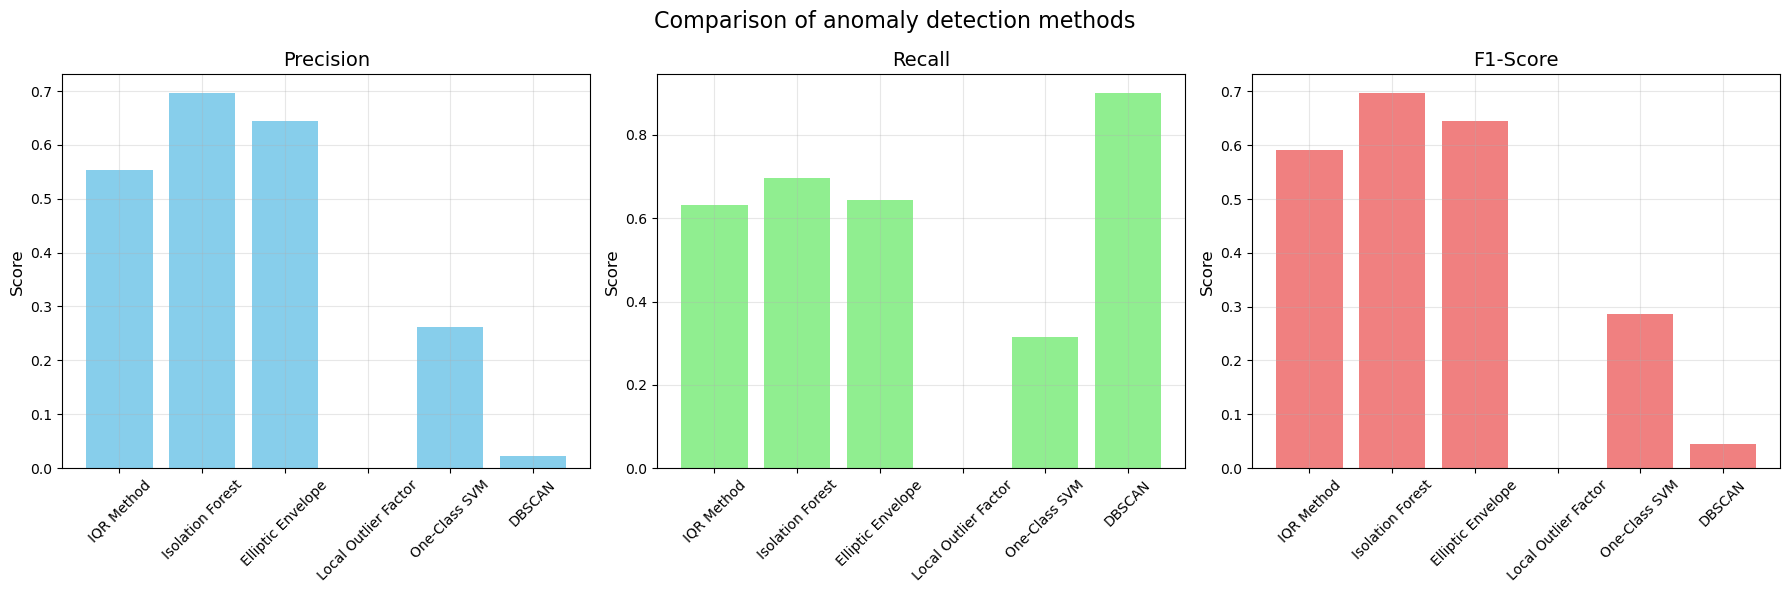

In [37]:
metrics_df = pd.DataFrame(results)
print("Summary table of results:")
print(metrics_df.round(4))
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].bar(metrics_df['method'], metrics_df['precision'], color='skyblue')
axes[0].set_title('Precision', fontsize=14)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)
axes[1].bar(metrics_df['method'], metrics_df['recall'], color='lightgreen')
axes[1].set_title('Recall', fontsize=14)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)
axes[2].bar(metrics_df['method'], metrics_df['f1_score'], color='lightcoral')
axes[2].set_title('F1-Score', fontsize=14)
axes[2].set_ylabel('Score', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Comparison of anomaly detection methods', fontsize=16)
plt.tight_layout()
plt.show()

In [39]:
best_precision = metrics_df.loc[metrics_df['precision'].idxmax()]
best_recall = metrics_df.loc[metrics_df['recall'].idxmax()]
best_f1 = metrics_df.loc[metrics_df['f1_score'].idxmax()]
print(f"BEST RESULTS:")
print(f"The best accuracy: {best_precision['method']} - {best_precision['precision']:.4f}")
print(f"Best review: {best_recall['method']} - {best_recall['recall']:.4f}")
print(f"The best F1 score: {best_f1['method']} - {best_f1['f1_score']:.4f}")
print(f"\nCOMPARISON WITH THE BASIC IQR METHOD:")
iqr_result = metrics_df[metrics_df['method'] == 'IQR Method'].iloc[0]

for _, row in metrics_df.iterrows():
    if row['method'] != 'IQR Method':
        precision_diff = row['precision'] - iqr_result['precision']
        recall_diff = row['recall'] - iqr_result['recall']
        f1_diff = row['f1_score'] - iqr_result['f1_score']
        print(f"\n{row['method']}:")
        print(f"  Precision: {row['precision']:.4f} ({precision_diff:+.4f})")
        print(f"  Recall: {row['recall']:.4f} ({recall_diff:+.4f})")
        print(f"  F1-score: {row['f1_score']:.4f} ({f1_diff:+.4f})")

BEST RESULTS:
The best accuracy: Isolation Forest - 0.6962
Best review: DBSCAN - 0.9006
The best F1 score: Isolation Forest - 0.6969

COMPARISON WITH THE BASIC IQR METHOD:

Isolation Forest:
  Precision: 0.6962 (+0.1425)
  Recall: 0.6977 (+0.0655)
  F1-score: 0.6969 (+0.1066)

Elliptic Envelope:
  Precision: 0.6435 (+0.0898)
  Recall: 0.6448 (+0.0127)
  F1-score: 0.6441 (+0.0538)

Local Outlier Factor:
  Precision: 0.0000 (-0.5537)
  Recall: 0.0000 (-0.6321)
  F1-score: 0.0000 (-0.5903)

One-Class SVM:
  Precision: 0.2623 (-0.2914)
  Recall: 0.3150 (-0.3171)
  F1-score: 0.2863 (-0.3041)

DBSCAN:
  Precision: 0.0227 (-0.5310)
  Recall: 0.9006 (+0.2685)
  F1-score: 0.0443 (-0.5460)
